# Example of getting nan in the first frequency.

This is an error that appears occasionally near the start of the sampling where a particular draw from the prior produces a nan value in the set of mixed mode frequencies. Dynesty can't handle nan so the sampling can't be initialized.

From what I can tell this problem occurs when prior draw produces a numax which is dramatically different from the target numax, in combination with when the asymptotic g-mode parameters are supplied manually. The asymptotic g-mode parameters are then vastly different from what shoudl be expected for that particular numax draw.

For some reason, when it comes to solving the eigen value problem of L and D to get the mixed mode frequencies, one of the eigenvalues Lambda becomes positive where they should be negative. Since the mode frequencies are given by $\omega = (-\Lambda)^2$, this results in that frequency being nan. 

We should in principle be able to ignore this issue in the future, since the prior will know what DPi0 goes with what numax, but it would be nice to know why we get positive $\Lambda$ values from the L and D matrices. 

In [5]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import corner
import jax.numpy as jnp
import pbjam.distributions as dist
import numpy as np
from scipy.linalg import eigh as seigh

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
psd = IO.psd('KIC7976303', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::10]

s = psd.powerdensity[::10]

Using cached search result.
Loading fits files from cache.


KeyboardInterrupt: 

## Priors and Observations

In [ ]:

addObs = {'numax' : (900.17, 80),
          'dnu'  : (51.24, 0.21),
          'teff': (6053, 10.0),
          'bp_rp': (0.719, 0.05), 
          } 

addPriors = {'p_L0': dist.beta(a=1.2, b=1.2, loc=0.04, scale=0.06),
             'p_D0': dist.beta(a=1.2, b=1.2, loc=-0.04, scale=0.04),
             'DPi0': dist.normal(loc=0.000519, scale=0.000519*0.01),
             'eps_g': dist.normal(loc=0.81, scale=0.01),
             'd01': dist.normal(loc=np.log10(24), scale=0.01),
             'alpha_g': dist.normal(loc=np.log10(0.02), scale=0.5),
            }

In [ ]:
N_p = 15

N_pca = 20

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

In [ ]:
v=jnp.array([ 1.26105197e+01, -2.09269972e+00, -1.58912585e+00, -7.15306882e-01,
             -1.01949253e+00, -2.16685269e-01,  6.60950953e-01,  1.09379960e+00,
              7.02136291e-02, -1.32866941e-02,  5.15077069e-04,  8.15679489e-01,
             -5.77050777e-01,  1.35431965e+00, -1.88545218e+00,  7.53681830e-01,
              2.23390255e+00, -2.78242778e-01,  2.05914413e+00,  4.56415754e-02])

r = M.unpackParams(v)

print(r)

In [58]:
sampler, samples = M(dynesty_kwargs = {'nlive':500})

24680it [10:11, 40.37it/s, +500 | bound: 311 | nc: 1 | ncall: 935790 | eff(%):  2.692 | loglstar:   -inf < -33125.476 <    inf | logz: -33174.274 +/-  0.309 | dlogz:  0.001 >  0.509]


In [66]:
nu1_p = nu0_p + d01  
    
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, DPi0, eps_g, alpha_g)

L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, p_L, p_D)

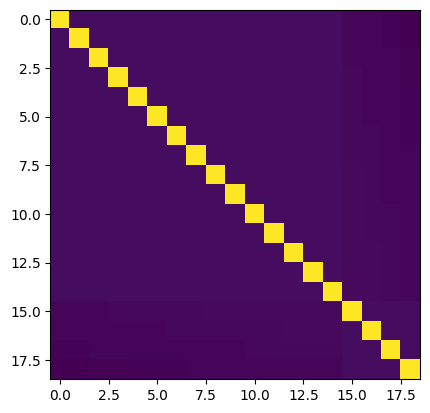

In [70]:
plt.imshow(D)

In [71]:
D

Array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01597929, -0.01946752, -0.02472401, -0.03353713],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01465422, -0.01785319, -0.02267379, -0.03075608],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01352855, -0.01648179, -0.0209321 , -0.02839355],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

In [72]:
Lambda, U = M.MixFreqModel.eigh(L, D)

In [78]:
Lambda, U

(Array([-6.35508027e-05, -5.84409597e-05, -5.35687277e-05, -4.89393112e-05,
        -4.45746218e-05, -4.06068787e-05, -3.79842937e-05, -3.56845652e-05,
        -3.22346564e-05, -2.87784773e-05, -2.55103466e-05, -2.25197279e-05,
        -2.05857233e-05, -1.91620931e-05, -1.66745411e-05, -1.42935338e-05,
        -1.27259534e-05, -1.16925582e-05, -8.49284194e-06], dtype=float64),
 Array([[ 3.08550834e-04,  2.55063069e-04,  1.04599703e-04,
          2.77652806e-04,  1.33690762e-03,  5.31208799e-03,
          1.55466538e-02,  1.10466950e-02,  6.80397494e-03,
          5.43565959e-03,  3.78620921e-03,  4.15649980e-03,
          4.55097210e-02,  4.00336553e-02,  3.28553044e-02,
          2.60266793e-02,  4.81597753e-01,  8.69033086e-01,
          9.65497885e-02],
        [ 1.78371517e-04,  7.57517952e-05, -1.57237705e-04,
          6.95974521e-04,  2.11965441e-03,  7.33046282e-03,
          2.04229820e-02,  1.41044877e-02,  8.46698479e-03,
          6.68201647e-03,  4.55363974e-03,  6.4504125

In [76]:
sLambda, sU = seigh(L, D)

In [79]:
sLambda, sU

(array([-6.35508027e-05, -5.84409597e-05, -5.35687277e-05, -4.89393112e-05,
        -4.45746218e-05, -4.06068787e-05, -3.79842937e-05, -3.56845652e-05,
        -3.22346564e-05, -2.87784773e-05, -2.55103466e-05, -2.25197279e-05,
        -2.05857233e-05, -1.91620931e-05, -1.66745411e-05, -1.42935338e-05,
        -1.27259534e-05, -1.16925582e-05, -8.49284194e-06]),
 array([[ 3.08550834e-04,  2.55063069e-04,  1.04599703e-04,
          2.77652806e-04, -1.33690762e-03, -5.31208799e-03,
         -1.55466538e-02,  1.10466950e-02, -6.80397494e-03,
         -5.43565959e-03,  3.78620921e-03, -4.15649980e-03,
         -4.55097210e-02,  4.00336553e-02, -3.28553044e-02,
         -2.60266793e-02,  4.81597753e-01,  8.69033086e-01,
         -9.65497885e-02],
        [ 1.78371517e-04,  7.57517952e-05, -1.57237705e-04,
          6.95974521e-04, -2.11965441e-03, -7.33046282e-03,
         -2.04229820e-02,  1.41044877e-02, -8.46698479e-03,
         -6.68201647e-03,  4.55363974e-03, -6.45041255e-03,
        

In [81]:
np.allclose(U, sU)

False

In [87]:
v=jnp.array([ 1.26105197e+01, -2.09269972e+00, -1.58912585e+00, -7.15306882e-01,
 -1.01949253e+00, -2.16685269e-01,  6.60950953e-01,  1.09379960e+00,
  7.02136291e-02, -1.32866941e-02,  5.15077069e-04,  8.15679489e-01,
 -5.77050777e-01,  1.35431965e+00, -1.88545218e+00,  7.53681830e-01,
  2.23390255e+00, -2.78242778e-01,  2.05914413e+00,  4.56415754e-02])

NameError: name 'M' is not defined

In [90]:
nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(r['numax'], r['dnu'], r['eps_p'], r['alpha_p'])

nu1_p = nu0_p + r['d01']  
    
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, r['DPi0'], r['eps_g'], r['alpha_g'])

L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, r['p_L'], r['p_D'])

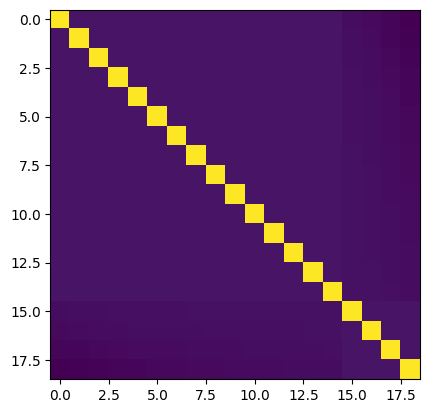

In [94]:
plt.imshow(D)

In [2]:
Lambda, U = M.MixFreqModel.eigh(L, D)

NameError: name 'M' is not defined

In [1]:
-Lambda

NameError: name 'Lambda' is not defined

In [98]:
sLambda, sU = seigh(L, D)